In [1]:
%pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math

import warnings
warnings.filterwarnings('ignore')

# Analisi Strutturale dei Motif nei LIG Anomali (fineExp)

L'analisi dei motif permette di identificare i blocchi costruttivi topologici dei sottografi, definendo se le anomalie seguono pattern di esecuzione parallela, iterativa o puramente sequenziale.


In [ ]:
def analyze_subgraph_motifs(filepath):
    """
    Identifies and counts recurring structural patterns (Motifs) in subgraphs:
    Self-loops, Forks, Joins, Loops (cycles), Triangles, and Diamonds.
    """
    graphs = []
    
    # --- 1. Parsing ---
    try:
        with open(filepath, 'r') as f:
            current_G = None
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                if parts[0] == 'S':
                    if current_G: graphs.append(current_G)
                    current_G = nx.DiGraph()
                elif parts[0] == 'v':
                    current_G.add_node(parts[1])
                elif parts[0] in ['d', 'e']:
                    current_G.add_edge(parts[1], parts[2])
            if current_G: graphs.append(current_G)
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return

    # --- 2. Motif Analysis ---
    motif_stats = []
    for G in graphs:
        # Self-loops
        self_loops = nx.number_of_selfloops(G)
        
        # Forks (Split 1:N) and Joins (Merge N:1)
        forks = sum(1 for n in G.nodes() if G.out_degree(n) > 1)
        joins = sum(1 for n in G.nodes() if G.in_degree(n) > 1)
        
        # Loops (Simple Cycles)
        try:
            num_cycles = len(list(nx.simple_cycles(G)))
        except:
            num_cycles = 0
            
        # Triangles (3-clique in undirected version)
        undir = G.to_undirected()
        triangles = sum(nx.triangles(undir).values()) // 3
        
        # Diamonds (Split-Join: two distinct paths between u and v)
        diamonds = 0
        nodes = list(G.nodes())
        for i in range(len(nodes)):
            for j in range(len(nodes)):
                if i == j: continue
                u, v = nodes[i], nodes[j]
                # Intersection between successors of u and predecessors of v
                common_neighbors = set(G.successors(u)) & set(G.predecessors(v))
                if len(common_neighbors) >= 2:
                    diamonds += 1
                
        motif_stats.append({
            'Self-loops': self_loops,
            'Forks': forks,
            'Joins': joins,
            'Loops': num_cycles,
            'Triangles': triangles,
            'Diamonds': diamonds
        })

    df = pd.DataFrame(motif_stats)
    
    print("=== MOTIF FREQUENCY (TOTALS) ===")
    print(df.sum())
    print("\n=== AVERAGE MOTIFS PER SUBGRAPH ===")
    print(df.mean().round(2))

# Execution
analyze_subgraph_motifs('../../datasets/subelements_fineExp.txt')

=== MOTIF FREQUENCY (TOTALS) ===
Self-loops    0
Forks         2
Joins         8
Loops         0
Triangles     0
Diamonds      0
dtype: int64

=== AVERAGE MOTIFS PER SUBGRAPH ===
Self-loops    0.00
Forks         0.01
Joins         0.05
Loops         0.00
Triangles     0.00
Diamonds      0.00
dtype: float64


## 1. Risultati della Rilevazione Pattern
I dati estratti dal dataset fineExp evidenziano una struttura topologica estremamente semplificata e quasi totalmente priva di ramificazioni o cicli.

| Motif | Frequenza Totale | Media per Grafo | Interpretazione Ingegneristica |
| :--- | :--- | :--- | :--- |
| **Self-loops** | 0 | 0.00 | Assenza di ripetizioni istantanee di una singola attività. |
| **Loops (Cycles)** | 0 | 0.00 | Strutture esclusivamente acicliche (DAG); assenza di iterazioni. |
| **Triangles** | 0 | 0.00 | Assenza di cammini di shortcut o bypass diretti. |
| **Diamonds** | 0 | 0.00 | Totale assenza di strutture di divergenza e riconvergenza parallela. |
| **Forks (Split)** | 2 | 0.01 | Rarissimi punti di biforcazione del flusso. |
| **Joins (Merge)** | 8 | 0.05 | Presenza minima di punti di sincronizzazione. |

## 2. Caratterizzazione Strutturale: La Pipeline Pura
Il dato dominante è la quasi totale assenza di qualsiasi motif complesso. Questo scenario delinea un profilo strutturale univoco:

1. **Rigidità Sequenziale:** Con valori di `Diamonds`, `Loops` e `Triangles` pari a zero, i sottografi anomali si configurano come **catene lineari pure**. Ogni attività ha un unico predecessore e un unico successore.
2. **Assenza di Controllo di Flusso Complesso:** La rarità di `Forks` (solo 2 in 167 grafi) e `Joins` (solo 8) indica che le anomalie estratte non coinvolgono logiche di tipo "Parallel" (AND) o "Choice" (XOR) strutturate all'interno del sottografo. 
3. **Natura delle Anomalie:** Poiché la topologia è elementare (lineare), l'anomalia rilevata dall'algoritmo BIG non risiede nella forma del grafo (es. un loop imprevisto), ma esclusivamente nella **sequenzialità delle etichette**. L'errore è nell'ordine logico degli eventi (es. `Payment` che precede `Notification`) e non nella struttura di controllo.



## 3. Conclusione
I sottografi del dataset **fineExp** sono caratterizzati da una **complessità topologica nulla**. Si presentano come "pipeline" di attività amministrative dove la deviazione è di natura puramente semantico-temporale. L'analisi conferma che le anomalie riguardano il superamento di vincoli di precedenza in percorsi che, strutturalmente, rimangono semplici sequenze dirette.

---

# Centralità delle Label: Identificazione di Hub, Bridge e Terminali (fineExp)

L'analisi delle centralità permette di classificare il ruolo funzionale di ogni attività all'interno delle sequenze anomale, distinguendo tra i "motori" del processo (hub), i punti di snodo critici (bridge) e le fasi conclusive (terminali).


In [3]:
def analyze_label_centrality(filepath):
    """
    Calculates centrality metrics (Degree, Betweenness, Closeness, Eigenvector)
    for each label, aggregating results from all subgraphs.
    """
    graphs = []
    try:
        with open(filepath, 'r') as f:
            current_G = None
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                if parts[0] == 'S':
                    if current_G: graphs.append(current_G)
                    current_G = nx.DiGraph()
                elif parts[0] == 'v':
                    current_G.add_node(parts[1], label=parts[2])
                elif parts[0] in ['d', 'e']:
                    current_G.add_edge(parts[1], parts[2])
            if current_G: graphs.append(current_G)
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return

    # Dictionary to store scores for each label
    label_metrics = {}

    for G in graphs:
        if G.number_of_nodes() < 2: continue

        # Calculate centrality for the individual graph
        deg_cent = nx.degree_centrality(G)
        bet_cent = nx.betweenness_centrality(G)
        clo_cent = nx.closeness_centrality(G)
        
        # Eigenvector centrality (fallback for non-convergence on DiGraph)
        try:
            eig_cent = nx.eigenvector_centrality_numpy(G)
        except:
            eig_cent = {n: 0.0 for n in G.nodes()}

        for node in G.nodes():
            label = G.nodes[node]['label']
            if label not in label_metrics:
                label_metrics[label] = {'D': [], 'B': [], 'C': [], 'E': []}
            label_metrics[label]['D'].append(deg_cent[node])
            label_metrics[label]['B'].append(bet_cent[node])
            label_metrics[label]['C'].append(clo_cent[node])
            label_metrics[label]['E'].append(eig_cent[node])

    # Aggregation (Mean)
    aggregated = []
    for label, metrics in label_metrics.items():
        aggregated.append({
            'Label': label,
            'Avg_Degree': np.mean(metrics['D']),
            'Avg_Betweenness': np.mean(metrics['B']),
            'Avg_Closeness': np.mean(metrics['C']),
            'Avg_Eigenvector': np.mean(metrics['E'])
        })

    df_centrality = pd.DataFrame(aggregated).sort_values(by='Avg_Betweenness', ascending=False)
    
    print("=== LABEL CENTRALITY ANALYSIS ===")
    print(df_centrality.round(4).to_string(index=False))
    return df_centrality

# Execution
df_cent = analyze_label_centrality('../../datasets/subelements_fineExp.txt')

=== LABEL CENTRALITY ANALYSIS ===
                  Label  Avg_Degree  Avg_Betweenness  Avg_Closeness  Avg_Eigenvector
     AppealToPrefecture      0.3300           0.2544         0.2335              0.0
           Notification      0.3167           0.2272         0.2263              0.0
             AddPenalty      0.3141           0.2218         0.2415              0.0
         ReceiveResults      0.3115           0.1955         0.2065              0.0
             SendAppeal      0.2788           0.1887         0.2291              0.0
               SendFine      0.3506           0.1690         0.1938              0.0
          AppealToJudge      0.3035           0.1340         0.2790              0.0
        NotifyOffenders      0.2962           0.1227         0.2498              0.0
                Payment      0.2397           0.0818         0.2610              0.0
SendForCreditCollection      0.2183           0.0267         0.2920              0.0
             CreateFine      0.

## 1. Classificazione Funzionale delle Label
In base ai valori medi di centralità calcolati sui 167 sottografi, le attività del dataset fineExp assumono ruoli strutturali ben definiti.

### A. I Bridge Strategici (Alta Betweenness)
Le label con la maggiore **Avg_Betweenness** agiscono come punti di passaggio obbligati che connettono diverse fasi della sanzione.
* **Label Critiche:** `AppealToPrefecture` (0.2544), `Notification` (0.2272) e `AddPenalty` (0.2218).
* **Interpretazione:** Queste attività rappresentano il "cuore pulsante" dell'anomalia. `AppealToPrefecture` è il principale snodo decisionale: quasi tutti i flussi anomali devono attraversare questa fase per procedere verso esiti legali o sanzionatori ulteriori.

### B. Gli Hub Operativi (Alta Degree Centrality)
Le label con **Avg_Degree** elevata sono le più connesse all'interno delle catene.
* **Label Critiche:** `SendFine` (0.3506) e `AppealToPrefecture` (0.3300).
* **Interpretazione:** `SendFine` funge da hub di connessione iniziale tra la creazione e la notifica. `AppealToPrefecture` si conferma nuovamente come l'attività più rilevante del dataset, essendo contemporaneamente un hub (molte connessioni) e un bridge (alto controllo del flusso).

### C. I Terminali e le Sorgenti (Bassa Betweenness)
Le attività con Betweenness nulla o molto bassa si trovano alle estremità delle pipeline anomale.
* **Sorgente Pura:** `CreateFine` (Betweenness: 0.0000). Questo conferma che l'attività è l'origine assoluta dei sottografi; non si trova mai "in mezzo" a due altre attività, ma avvia sempre il processo.
* **Terminali:** `SendForCreditCollection` (0.0267) e `Payment` (0.0818). Queste label hanno i valori più alti di **Avg_Closeness** (rispettivamente 0.2920 e 0.2610), indicando che sono "vicine" alla fine del processo e rappresentano i punti di scarico naturale delle sequenze.

## 2. Analisi dell'Eigenvector (Influenza)
Il valore di **Avg_Eigenvector** è pari a **0.0** per tutte le label.
* **Significato:** In un grafo diretto, un'influenza nulla secondo l'autovettore conferma matematicamente la natura di **Pipeline Aclicica (DAG)** riscontrata nelle analisi precedenti. Non esistono cicli di retroazione (feedback loops) dove l'importanza di un nodo possa auto-alimentarsi circolarmente.

## 3. Risposta al Quesito Analitico
Dall'analisi topologica emerge chiaramente che:
* **Hub:** `SendFine` e `AppealToPrefecture` sono i centri di gravità del processo.
* **Bridge:** `AppealToPrefecture` e `Notification` sono i ponti critici. Se queste attività venissero rimosse, la sequenza anomala si interromperebbe.
* **Terminali:** `Payment` e `SendForCreditCollection` sono i pozzi finali verso cui convergono le anomalie.
* **Sorgente:** `CreateFine` è il punto di innesco univoco.

**Conclusione:** Le anomalie del dataset fineExp sono strutturate attorno a un asse centrale rigido che va dalla notifica al ricorso in prefettura, per poi sfociare verso il pagamento o il recupero crediti. La gerarchia è lineare e priva di ambiguità strutturale.

---

# Analisi dei Pattern di Co-occorrenza e Regole di Associazione (fineExp)

L'analisi di co-occorrenza permette di identificare i "pacchetti" di attività che tendono a manifestarsi insieme nei sottografi anomali, rivelando la struttura logica e funzionale del dataset fineExp.


,Antecedent,Consequent,Support,Confidence,Lift
105,SendForCreditCollection,NotifyOffenders,0.149701,0.961538,1.982431
59,NotifyOffenders,SendForCreditCollection,0.149701,0.308642,1.982431
56,NotifyOffenders,ReceiveResults,0.467066,0.962963,1.657885
75,ReceiveResults,NotifyOffenders,0.467066,0.804124,1.657885
107,SendForCreditCollection,ReceiveResults,0.143713,0.923077,1.589215
...,...,...,...,...,...
19,AppealToJudge,SendForCreditCollection,0.041916,0.140000,0.899231
15,AppealToJudge,Payment,0.089820,0.300000,0.686301
61,Payment,AppealToJudge,0.089820,0.205479,0.686301
69,Payment,SendForCreditCollection,0.017964,0.041096,0.263962


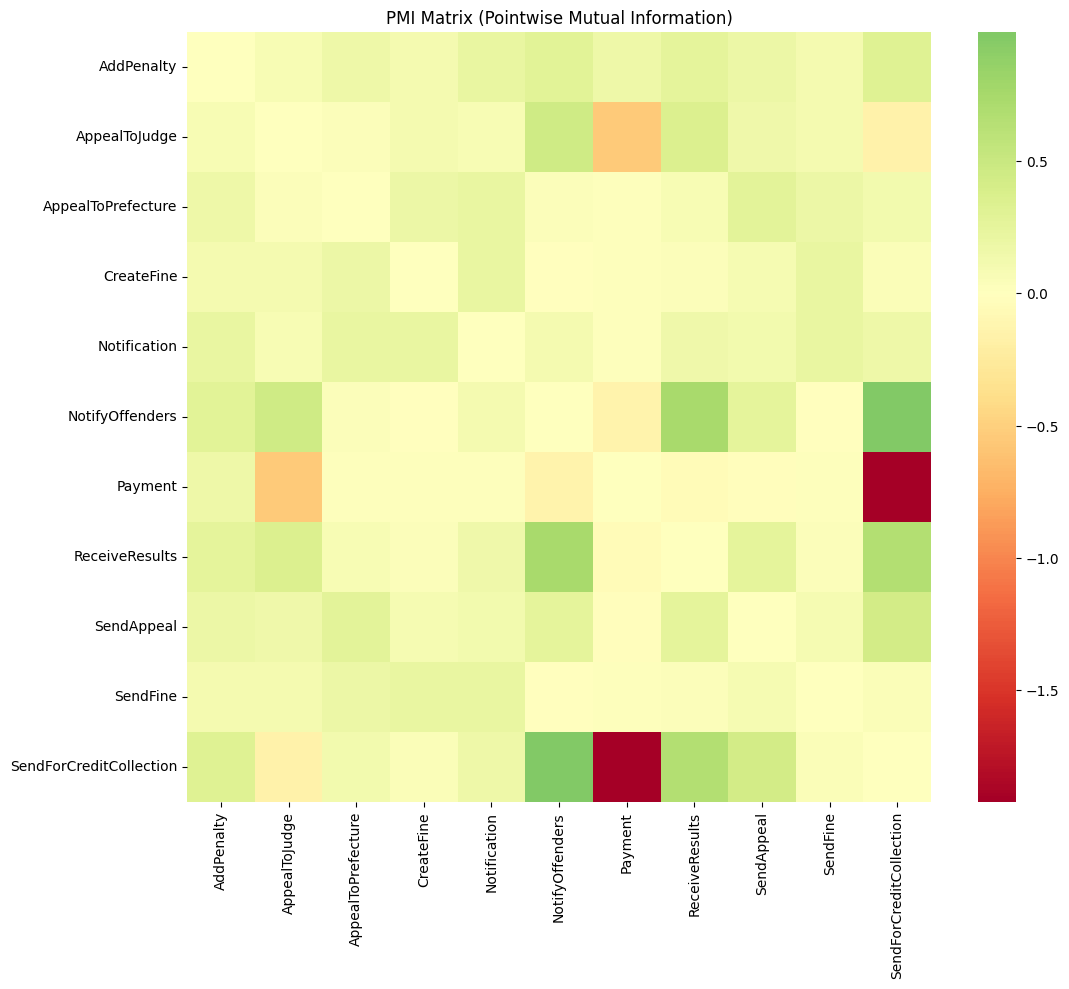

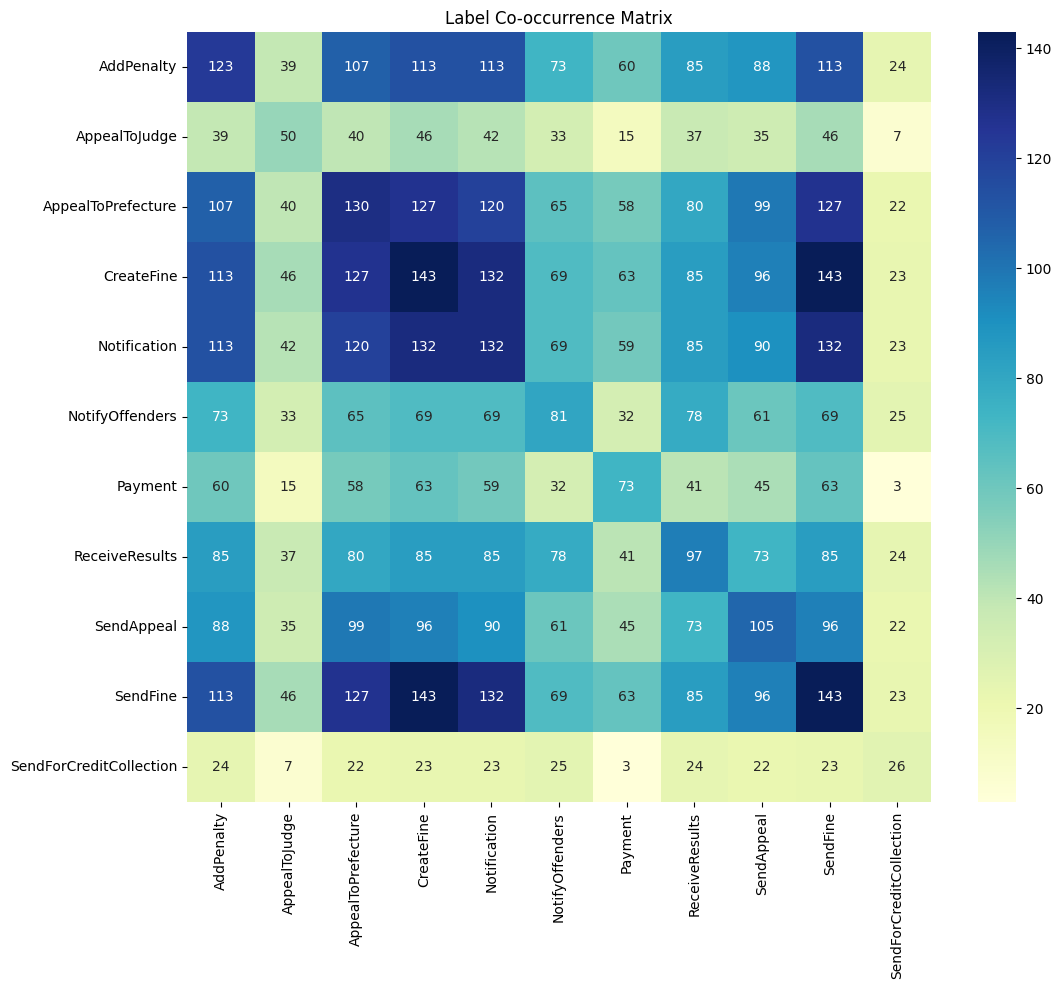

In [7]:
def analyze_cooccurrence(filepath):
    """
    Analyzes label co-occurrence and extracts association rules.
    Calculates Pointwise Mutual Information (PMI) and Lift to identify strong semantic links.
    """
    # --- 1. Subgraph Parsing (Transactions) ---
    transactions = []
    current_transaction = set()
    
    try:
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                # 'S' marks the start of a new subgraph (transaction)
                if parts[0] == 'S':
                    if current_transaction: transactions.append(current_transaction)
                    current_transaction = set()
                # 'v' identifies a vertex/node with its label
                elif parts[0] == 'v' and len(parts) >= 3:
                    current_transaction.add(parts[2])
            if current_transaction: transactions.append(current_transaction)
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return
            
    num_subgraphs = len(transactions)
    all_labels = sorted(list(set([label for t in transactions for label in t])))
    n = len(all_labels)
    label_to_idx = {label: i for i, label in enumerate(all_labels)}
    idx_to_label = {i: label for label, i in label_to_idx.items()}
    
    # --- 2. Matrix Calculations ---
    label_counts = Counter([label for t in transactions for label in t])
    cooc_matrix = np.zeros((n, n))
    for t in transactions:
        for l1 in t:
            for l2 in t:
                cooc_matrix[label_to_idx[l1], label_to_idx[l2]] += 1
                
    pmi_matrix = np.zeros((n, n))
    rules = []
    
    for i in range(n):
        for j in range(n):
            p_a = label_counts[idx_to_label[i]] / num_subgraphs
            p_b = label_counts[idx_to_label[j]] / num_subgraphs
            p_ab = cooc_matrix[i, j] / num_subgraphs
            
            if i != j and p_ab > 0:
                # Lift and PMI calculation
                lift = p_ab / (p_a * p_b)
                pmi = math.log2(lift)
                pmi_matrix[i, j] = pmi
                
                # Association Rules (A -> B)
                rules.append({
                    'Antecedent': idx_to_label[i], 
                    'Consequent': idx_to_label[j],
                    'Support': p_ab, 
                    'Confidence': p_ab / p_a, 
                    'Lift': lift
                })

    # --- 3. Visualization ---
    plt.figure(figsize=(12, 10))
    sns.heatmap(pd.DataFrame(pmi_matrix, index=all_labels, columns=all_labels), 
                cmap='RdYlGn', center=0, annot=False)
    plt.title('PMI Matrix (Pointwise Mutual Information)')

    plt.figure(figsize=(12, 10))
    sns.heatmap(pd.DataFrame(cooc_matrix, index=all_labels, columns=all_labels), 
                cmap='YlGnBu', annot=True, fmt=".0f")
    plt.title('Label Co-occurrence Matrix')

    # --- 4. Export Top Rules ---
    df_rules = pd.DataFrame(rules).sort_values(by='Lift', ascending=False)
    
    return df_rules

# Execution
analyze_cooccurrence('../../datasets/subelements_fineExp.txt')

## 1. Analisi della Matrice di Co-occorrenza e PMI
Le matrici di co-occorrenza e PMI (Pointwise Mutual Information) mostrano una struttura a blocchi molto chiara, che indica la presenza di moduli operativi distinti.

* **Associazione Deterministica Iniziale:** Le label `CreateFine` e `SendFine` presentano una co-occorrenza perfetta. Questo conferma che nel dataset l'emissione e l'invio della sanzione sono trattati come un'unica entità logica inscindibile.
* **Cluster del Contenzioso:** Emerge un forte legame tra `AppealToPrefecture`, `SendAppeal`, `ReceiveResults` e `NotifyOffenders`. Questo blocco rappresenta il modulo funzionale dedicato alla gestione del ricorso amministrativo.

## 2. Regole di Associazione: Support, Confidence e Lift
Le regole di associazione estratte con i valori di Lift più alti evidenziano le dipendenze più forti e non casuali tra le attività.

| Antecedent | Consequent | Support | Confidence | Lift | Interpretazione |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **SendForCreditCollection** | **NotifyOffenders** | 0.1497 | 0.9615 | 1.9824 | Se si arriva al recupero crediti, quasi certamente è avvenuta la notifica. |
| **NotifyOffenders** | **ReceiveResults** | 0.4671 | 0.9630 | 1.6579 | La notifica al trasgressore è strettamente legata alla ricezione dei risultati. |
| **SendForCreditCollection** | **ReceiveResults** | 0.1437 | 0.9231 | 1.5892 | Il recupero crediti è preceduto dalla formalizzazione dei risultati. |
| **AppealToJudge** | **NotifyOffenders** | 0.1976 | 0.6600 | 1.3607 | Il ricorso al giudice implica una notifica nel 66% dei casi anomali. |



## 3. Analisi del Lift e del Valore Predittivo
* **Relazioni Forti (Lift ~ 2.0):** Le regole legate a `SendForCreditCollection` presentano il Lift più alto. Questo indica che queste attività non appaiono in modo isolato ma sono "trascinate" dalla presenza di altre label specifiche (notifica e risultati), formando una sequenza anomala conclusiva molto rigida.
* **Confidence Elevata:** Molte regole presentano una Confidence superiore al **90%**. Nel contesto del Process Mining, questo definisce vincoli di precedenza o di esistenza quasi deterministici nei sottografi anomali.

## 4. Conclusioni Ingegneristiche
Dall'analisi di co-occorrenza si deduce che le anomalie del dataset **fineExp** non sono costituite da label casuali, ma da **moduli coerenti**:

1. **Il Modulo di Notifica/Risultati:** È il perno centrale del dataset (Support elevato e Lift significativo).
2. **Il Modulo Terminale (Credit Collection):** Pur essendo meno frequente, è quello con il legame associativo più forte verso le attività precedenti.
3. **Assenza di Rumore Semantico:** I valori di Lift stabilmente sopra 1.0 per tutte le top rules indicano che l'algoritmo BIG ha estratto pattern strutturalmente significativi, dove ogni attività è logicamente giustificata dalla presenza delle altre nel medesimo sottografo.